In [1]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pywt
import wfdb
import math
import sklearn
import keras.backend as K
from tensorflow.keras.metrics import Precision, Recall
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from skimage.restoration import denoise_wavelet
from random import shuffle
from tqdm import tqdm

In [2]:
tags_ecg_feas1 = pd.read_csv(r"Data\\feas1\\rec_data_anon.csv")
tags_pt_feas1 = pd.read_csv(r"Data\\feas1\\pt_data_anon.csv")
key_1 = {'AF':2, 'maybeAF':3, 'noAF':4, 'other':1, 'undecided':6}
tags_ecg_feas2 = pd.read_csv(r"Data\\feas2\\rec_data_anon.csv")
tags_pt_feas2 = pd.read_csv(r"Data\\feas2\\pt_data_anon.csv")
key_2 = {'AF':1, 'maybeAF':2, 'noAF':3, 'noisy':4, 'undecided':6}
tags_ecg_trial = pd.read_csv(r"Data\\trial\\rec_data_anon_20240118.csv")
tags_pt_trial = pd.read_csv(r"Data\\trial\\pt_data_anon.csv")
key_t = {'AF':1, 'maybeAF':2, 'noAF':3, 'other':4, 'noisy':5, 'undecided':6}

C:\Users\docto\AppData\Local\Temp\ipykernel_3984\3583887908.py:7: DtypeWarning: Columns (35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  tags_ecg_trial = pd.read_csv(r"Data\\trial\\rec_data_anon_20240118.csv")


In [3]:
def generate_filter(fs=500, low_cut=0.6, high_cut=40, N=1):
    return signal.butter(N=N, Wn=[low_cut, high_cut], btype='bandpass', analog=False, output='sos', fs=fs)
    # return signal.butter(N=N, Wn=high_cut, btype='lowpass', analog=False, output='sos', fs=fs)

def apply_filters(ecg_signal, sos):
    return signal.sosfilt(sos, ecg_signal)

def filter_signal(ecg_signal, sos, N=5):
    ecg_filtered = remove_trend(ecg_signal)
    if N:
        for _ in range(N):
            ecg_filtered = apply_filters(ecg_filtered, sos)
    else:
        ecg_filtered = apply_filters(ecg_filtered, sos)
    return ecg_filtered

def remove_trend(ecg_signal, levels=8):
    DWTcoeffs = pywt.wavedec(ecg_signal, 'sym3')
    for i in range(1,levels):
        DWTcoeffs[-i] = np.zeros_like(DWTcoeffs[-i])
    ecg_filtered = np.array(ecg_signal) - pywt.waverec(DWTcoeffs,'sym3',mode='symmetric',axis=-1)
    return ecg_filtered

def normalise_signals(ecg_signals):
    norm_ecg_signals = []
    for i in ecg_signals:
        norm_ecg_signals.append((np.array(i)-np.mean(i))/np.std(i))
    return norm_ecg_signals

def remove_jumps(ecg_signal_orig):
    ecg_signal = np.copy(ecg_signal_orig)
    diff = np.diff(ecg_signal)
    avg_diff = np.average(np.abs(diff))
    for j, i in enumerate(diff):
        if j < 50: 
            if i > 3*avg_diff:
                if -np.min(diff[j:j+50]) < 0.5*i or i > 6*avg_diff:
                    ecg_signal[j+1:] -= i
            elif i < -3*avg_diff:
                if j == 0:
                    ecg_signal[j+1:] -= i
                elif np.max(diff[:j]) < -0.5*i or i < -6*avg_diff:
                    ecg_signal[j+1:] -= i
        elif i > 3*avg_diff:
            if -np.min(diff[j:j+50]) < 0.5*i or i > 6*avg_diff:
                ecg_signal[j+1:] -= i
        elif i < -3*avg_diff:
            if np.max(diff[j-50:j]) < -0.5*i or i < -6*avg_diff:
                ecg_signal[j+1:] -= i
    return ecg_signal

def filter_signals(ecg_signals, low_cut=0.6, high_cut=40, N=1):
    sos = generate_filter(low_cut=low_cut, high_cut=high_cut, N=N)
    ecg_signals_filtered = [None]*len(ecg_signals)
    for j in range(len(ecg_signals)):
        ecg_signals_filtered[j] = filter_signal(remove_jumps(ecg_signals[j]), sos)
    return normalise_signals(np.array(ecg_signals_filtered))
    
def performance(y_true, y_pred):
    TP = sum([1 for i, j in zip(y_true, y_pred) if i == 1 and j == 1])
    FP = sum([1 for i, j in zip(y_true, y_pred) if i == 0 and j == 1])
    FN = sum([1 for i, j in zip(y_true, y_pred) if i == 1 and j == 0])
    TN = sum([1 for i, j in zip(y_true, y_pred) if i == 0 and j == 0])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2*(precision*recall)/(precision + recall)

    return [f1_score, precision, recall, [[TP, FP], [FN, TN]]]

In [4]:
class ecg:

    def __init__(self, tags_ecg_feas1 = tags_ecg_feas1, tags_pt_feas1 = tags_pt_feas1, 
                 tags_ecg_feas2 = tags_ecg_feas2, tags_pt_feas2 = tags_pt_feas2, 
                 key_1 = key_1, key_2 = key_2):
        self.tags_ecg_1 = np.array(pd.DataFrame(tags_ecg_feas1))
        self.tags_pt_1 = np.array(pd.DataFrame(tags_pt_feas1))
        self.tags_ecg_2 = np.array(pd.DataFrame(tags_ecg_feas2))
        self.tags_pt_2 = np.array(pd.DataFrame(tags_pt_feas2))
        self.tags_ecg_t = np.array(pd.DataFrame(tags_ecg_trial))
        self.tags_pt_t = np.array(pd.DataFrame(tags_pt_trial))

        self.tags_pt_ecg_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_ecg_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_ecg_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['ptID', 'measNo', 'measID']))
        self.tags_pt_info_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['ptID', 'ptDiag', 'measID', 'measDiag']))
        self.tags_pt_info_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['ptID', 'ptDiag', 'measID', 'measDiag']))
        self.tags_pt_info_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['ptID', 'ptDiag', 'measID', 'measDiag']))
        self.tags_pt_diag_1 = np.array(pd.DataFrame(tags_pt_feas1, columns=['ptID', 'ptDiag']))
        self.tags_pt_diag_2 = np.array(pd.DataFrame(tags_pt_feas2, columns=['ptID', 'ptDiag']))
        self.tags_pt_diag_t = np.array(pd.DataFrame(tags_pt_trial, columns=['ptID', 'ptDiag']))
        self.tags_ecg_info_1 = np.array(pd.DataFrame(tags_ecg_feas1, columns=['measID', 'measDiag', 'ptDiag', 'measDiagAgree']))
        self.tags_ecg_info_2 = np.array(pd.DataFrame(tags_ecg_feas2, columns=['measID', 'measDiag', 'ptDiag']))
        self.tags_ecg_info_t = np.array(pd.DataFrame(tags_ecg_trial, columns=['measID', 'measDiag', 'ptDiag', 'measDiagAgree']))

        self.key_1 = key_1
        self.key_2 = key_2
        self.key_t = key_t
        self.ecg_num_1 = 162515
        self.ecg_num_2 = 23253
        self.ecg_num_t = 1104005
        self.pt_num_1 = 2141
        self.pt_num_2 = 288
        self.pt_num_t = 13453

    def extract_signal(self, measID, study = 'feas1'):
        if study == 'feas1':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_1, self.ecg_num_1, 'saferF1_pt'
        elif study == 'feas2':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_2, self.ecg_num_2, 'saferF2_pt'
        elif study == 'trial':
            ecg_IDs, num_ecgs, file_head = self.tags_pt_ecg_t, self.ecg_num_t, 'saferT_pt'

        assert measID < num_ecgs and measID == ecg_IDs[measID-1,-1]
        ptID, measNo = ecg_IDs[measID-1,0], ecg_IDs[measID-1,1]
        ptID_vis, folder_vis = self.file_strs(ptID)

        try:
            ecg_signal = wfdb.rdrecord('Data\\ECGs\\'+study+'\\'+folder_vis+'\\'+file_head+ptID_vis)
        except FileNotFoundError:
            # print('Incorrect .dat file assigned to patient '+str(ptID)+' for study '+study)
            return
        except TypeError:
            # print('Weird error for measID '+str(measID)+' for study '+study)
            return
        
        if len(ecg_signal.p_signal[0]) < measNo:
            print('Expected measurement '+str(measNo)+' for patient '+str(ptID)+' for study '+study+' not in file')
        else:
            return np.array(ecg_signal.p_signal[:,measNo-1])
    
    def file_strs(self, ptID):
        ptID_vis = '0'*(6-len(str(ptID)))+str(ptID)
        folder_vis = '0'*(4-len(str(ptID//100)))+str(ptID//100)+'0'*2
        return ptID_vis, folder_vis
        
    def extract_tags(self, measID_num, study = 'feas2'):
        if study == 'feas2':
            if measID_num > self.ecg_num_2: raise Exception('Not a valid measID')
            tags = self.tags_ecg_2[measID_num-1]
        elif study == 'feas1':
            if measID_num > self.ecg_num_1: raise Exception('Not a valid measID')
            tags = self.tags_ecg_1[measID_num-1]
        elif study == 'trial':
            if measID_num > self.ecg_num_t: raise Exception('Not a valid measID')
            tags = self.tags_ecg_t[measID_num-1]
        assert tags['measID'] == measID_num                   
        return tags
    
    def extract_label(self, tags):
        return tags['measDiag']
    
    def extract_ptDiag(self, ptID, study = 'trial'):
        if study == 'feas1':
            pt_info = self.tags_pt_diag_1
        elif study == 'feas2':
            pt_info = self.tags_pt_diag_2
        elif study == 'trial':
            pt_info = self.tags_pt_diag_t

        assert pt_info[ptID-1][0] == ptID
        return pt_info[ptID-1][1]
    
    def extract_measDiag(self, measIDs, study = 'trial'):
        if study == 'feas1':
            pt_info = self.tags_pt_info_1
        elif study == 'feas2':
            pt_info = self.tags_pt_info_2
        elif study == 'trial':
            pt_info = self.tags_pt_info_t

        measDiags = []
        for i in measIDs:
            assert pt_info[i-1][2] == i
            measDiags.append(pt_info[i-1][3])
        return measDiags
    
    def extract_cardiolund_tags(self, tags, study = 'feas2'):
        if study == 'feas2':
            cld_tags = list(tags.iloc[22:37]) 
        elif study == 'feas1':
            cld_tags =  list(tags.iloc[25:40])
        elif study == 'trial':
            cld_tags =  list(tags.iloc[25:40])
        # if 1 in [1 for i in cld_tags if math.isnan(i)]:
        if any(math.isnan(cld_tags)):
            return None
        else:
            return cld_tags
        
    def test_clean(self, measID, study = 'feas2'):
        if study == 'feas2':
            cld_tags = self.tags_ecg_2[measID-1][23:35]
        elif study == 'feas1':
            cld_tags =  self.tags_ecg_1[measID-1][26:46]
        elif study == 'trial':
            cld_tags =  self.tags_ecg_t[measID-1][23:35]
            
        if all(cld_tags == 0):
            return True
        else:
            return False
        
    def test_noisy(self, measID, study = 'trial'):
        if study == 'feas2':
            cld_noisy = self.tags_ecg_2[measID-1][30]
            diag = self.tags_ecg_2[measID-1][15]
        elif study == 'feas1':
            cld_noisy =  self.tags_ecg_1[measID-1][33]
            diag = self.tags_ecg_1[measID-1][18]
        elif study == 'trial':
            cld_noisy =  self.tags_ecg_t[measID-1][30]
            diag = self.tags_ecg_t[measID-1][15]
            
        if cld_noisy == 1 or diag == 5:
            return True
        else:
            return False
    
    def extract_pt_measIDs(self, ptID_num, study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_ecg_2
            ecg_num = self.ecg_num_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_ecg_1
            ecg_num = self.ecg_num_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_ecg_t
            ecg_num = self.ecg_num_t
        ptID_measIDs = []
        i = [j[0] for j in tags_ecg].index(ptID_num)
        while i < ecg_num and tags_ecg[i][0] == ptID_num:
            ptID_measIDs.append(tags_ecg[i][-1])
            i += 1
        return ptID_measIDs
    
    def extract_measID_pt(self, measID_num, study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_ecg_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_ecg_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_ecg_t
        return [j[0] for j in tags_ecg if j[2] == measID_num][0]
    
    def extract_measIDs(self, tag = 'AF', study = 'feas2', clean = True):
        if study == 'feas1':
            tags_ecg, key = self.tags_ecg_info_1, self.key_1
        elif study == 'feas2':
            tags_ecg, key = self.tags_ecg_info_2, self.key_2
        elif study == 'trial':
            tags_ecg, key = self.tags_ecg_info_t, self.key_t

        diag = key[tag]
        if tag == 'noAF':
            diag_undec = key['undecided']
            # if study == 'feas1':
            #     diag_noAF = [diag]
            # elif study == 'feas2':
            #     diag_noAF = [diag, key['other']]
            # elif study == 'trial':
            #     diag_noAF = [diag, key['other']]
            measIDs = [i[0] for i in tags_ecg if i[1] == diag] #  or (i[1] == diag_undec and i[2] == diag)
            if clean:
                return [i for i in measIDs if self.test_clean(i, study=study)]
            else:
                return measIDs
        else:
            return [i[0] for i in tags_ecg if i[1] == diag]
    
    def extract_ptIDs(self, tag = 'AF', study = 'feas2'):
        if study == 'feas2':
            tags_ecg = self.tags_pt_info_2
            key = self.key_2
        elif study == 'feas1':
            tags_ecg = self.tags_pt_info_1
            key = self.key_1
        elif study == 'trial':
            tags_ecg = self.tags_pt_info_t
            key = self.key_t
        
        diag = key[tag]
        return [i[0] for i in tags_ecg if i[1] == diag]
    
    def store_ecg_tags(self, tag = 'AF', study = 'feas2', measIDs = None):
        if measIDs is None: 
            measIDs = self.extract_measIDs(tag=tag, study=study)
        data = []
        for i in measIDs:
            tags = self.extract_tags(i, study = study)
            cdl_tags = self.extract_cardiolund_tags(tags, study = study)
            if cdl_tags is not None:
                data.append(cdl_tags)
        return data
    
    def store_ecg_data(self, tag = 'AF', study = 'feas2', measIDs = None, length = None, clean = True, permute = True):
        if type(measIDs) != list:
            measIDs = self.extract_measIDs(tag=tag, study=study, clean=clean)

        if length and length < len(measIDs):
            measIDs = np.random.permutation(measIDs)[:length]
        elif permute:
            measIDs = np.random.permutation(measIDs)

        data = []
        for i in tqdm(measIDs):
            extracted_signal = self.extract_signal(i, study=study)
            if type(extracted_signal) == np.ndarray:
                data.append(extracted_signal)
        return data, measIDs


In [5]:
ecg = ecg()

In [6]:
# Find all meas viewed by cardiologists

ecg_tags_reviewed = [i for i in ecg.tags_pt_info_t if i[3] != 6]
ecg_tags_AF = [i for i in ecg_tags_reviewed if i[3] == 1]

In [7]:
# Convert to list of patients viewed, and list of patients with AF

print(len(ecg_tags_reviewed))
patients_expanded = [j[0] for j in ecg_tags_reviewed]
patients_expanded_AF = [j[0] for j in ecg_tags_AF]
patients_reviewed = [i for i in range(13453) if i in patients_expanded]
patients_AF = [i for i in range(13453) if i in patients_expanded_AF]
print(len(patients_reviewed), len(patients_AF))

69963
6544 461


In [26]:
# Select 3/4 of patients for CNN training, leave 1/4 for testing

shuffle(patients_reviewed)
ntrain_CNN = round(len(patients_reviewed)*3/4)
pt_train = patients_reviewed[:ntrain_CNN]
pt_test = patients_reviewed[ntrain_CNN:]
print(len(pt_train), len(pt_test))
print(sum([1 for i in pt_train if i in patients_AF]), sum([1 for i in pt_test if i in patients_AF]))

4908 1636
351 110


In [27]:
# Convert list of patients to list of measIDs

meas_train = [i[2] for i in ecg_tags_reviewed if i[0] in pt_train]
meas_test = [i[2] for i in ecg.tags_pt_info_t if i[0] in pt_test and not ecg.test_clean(i[2], study = 'trial')]

In [28]:
data_AF_feas1, measIDs_AF_feas1 = ecg.store_ecg_data(tag='AF', study='feas1')
data_noAF_feas1, measIDs_noAF_feas1 = ecg.store_ecg_data(tag='noAF', study='feas1', clean=False)
print(len(measIDs_AF_feas1), len(measIDs_noAF_feas1))

data_AF_trial, measIDs_AF_trial = ecg.store_ecg_data(tag='AF', study='trial')
data_noAF_trial, measIDs_noAF_trial = ecg.store_ecg_data(tag='noAF', study='trial', length=10000, clean=False)
print(len(measIDs_AF_trial), len(measIDs_noAF_trial))

100%|██████████| 3127/3127 [02:12<00:00, 23.68it/s]


822 3127


100%|██████████| 10000/10000 [06:55<00:00, 24.06it/s]

2387 10000


In [34]:
# Split data into CNN and for testing

train_AF_idxs = []
test_AF_idxs = []
train_noAF_idxs = []
test_noAF_idxs = []

for i in range(len(measIDs_AF_trial)):
    if measIDs_AF_trial[i] in meas_train:
        train_AF_idxs.append(i)
    elif measIDs_AF_trial[i] in meas_test:
        test_AF_idxs.append(i)
    else:
        print(measIDs_AF_trial[i], 'Error')

for i in range(len(measIDs_noAF_trial)):
    if measIDs_noAF_trial[i] in meas_train:
        train_noAF_idxs.append(i)
    elif measIDs_noAF_trial[i] in meas_test:
        test_noAF_idxs.append(i)
    else:
        print(measIDs_noAF_trial[i], 'Error')

measIDs_pt_test_AF, data_AF_trial, measIDs_AF_trial = np.array(measIDs_AF_trial)[test_AF_idxs], np.array(data_AF_trial)[train_AF_idxs, :], np.array(measIDs_AF_trial)[train_AF_idxs]
measIDs_pt_test_noAF, data_noAF_trial, measIDs_noAF_trial = np.array(measIDs_noAF_trial)[test_noAF_idxs], np.array(data_noAF_trial)[train_noAF_idxs, :], np.array(measIDs_noAF_trial)[train_noAF_idxs]

print(len(measIDs_AF_trial), len(measIDs_noAF_trial))

1918 7494


In [35]:
ntrain = 5000
nval = 1200
ntest = 1200

ptrainAF = 0.25
pvalAF = 0.5
ptestAF = 0.5

ntrainAF = round(ntrain*ptrainAF)
nvalAF = round(nval*pvalAF)
ntestAF = round(ntest*ptestAF)

trial_cut = ntrainAF + nvalAF - ntestAF

data_AF, measIDs_AF = list(data_AF_feas1) + list(data_AF_trial[:trial_cut]), list(measIDs_AF_feas1) + list(measIDs_AF_trial[:trial_cut])
studies_AF = np.array(['feas1']*len(data_AF_feas1) + ['trial']*trial_cut)
permutation = np.random.permutation(np.array(data_AF).shape[0])
data_AF, measIDs_AF, studies_AF = np.array(data_AF)[permutation,:], np.array(measIDs_AF)[permutation], np.array(studies_AF)[permutation]

data_train_AF, measIDs_train_AF, studies_train_AF = data_AF[:ntrainAF], measIDs_AF[:ntrainAF], studies_AF[:ntrainAF]
data_val_AF, measIDs_val_AF, studies_val_AF = data_AF[ntrainAF:], measIDs_AF[ntrainAF:], studies_AF[ntrainAF:]
data_test_AF, measIDs_test_AF, studies_test_AF = data_AF_trial[trial_cut:trial_cut+ntestAF], measIDs_AF_trial[trial_cut:trial_cut+ntestAF], np.array(['trial']*ntestAF)

data_train_noAF, measIDs_train_noAF, studies_train_noAF = data_noAF_trial[:ntrain-ntrainAF], measIDs_noAF_trial[:ntrain-ntrainAF], np.array(['trial']*(ntrain-ntrainAF))
data_val_noAF, measIDs_val_noAF, studies_val_noAF = data_noAF_trial[ntrain-ntrainAF:ntrain+nval-ntrainAF-nvalAF], measIDs_noAF_trial[ntrain-ntrainAF:ntrain+nval-ntrainAF-nvalAF], np.array(['trial']*(nval-nvalAF))
data_test_noAF, measIDs_test_noAF, studies_test_noAF = data_noAF_trial[ntrain+nval-ntrainAF-nvalAF:ntrain+nval+ntest-ntrainAF-nvalAF-ntestAF], measIDs_noAF_trial[ntrain+nval-ntrainAF-nvalAF:ntrain+nval+ntest-ntrainAF-nvalAF-ntestAF], np.array(['trial']*(ntest-ntestAF))

In [36]:
data_train, measIDs_train, studies_train = np.concatenate((data_train_AF, data_train_noAF)), np.concatenate((measIDs_train_AF, measIDs_train_noAF)), np.concatenate((studies_train_AF, studies_train_noAF))
ytrain = np.array([1.0]*len(data_train_AF) + [0.0]*len(data_train_noAF))
data_val, measIDs_val, studies_val = np.concatenate((data_val_AF, data_val_noAF)), np.concatenate((measIDs_val_AF, measIDs_val_noAF)), np.concatenate((studies_val_AF, studies_val_noAF))
yval = np.array([1.0]*len(data_val_AF) + [0.0]*len(data_val_noAF))
data_test, measIDs_test, studies_test = np.concatenate((data_test_AF, data_test_noAF)), np.concatenate((measIDs_test_AF, measIDs_test_noAF)), np.concatenate((studies_test_AF, studies_test_noAF))
ytest = np.array([1.0]*len(data_test_AF) + [0.0]*len(data_test_noAF))

print(len(ytrain), np.sum(ytrain))
print(len(yval), np.sum(yval))
print(len(ytest), np.sum(ytest))

5000 1250.0
1417 817.0
1200 600.0


In [37]:
xtrain = np.array(filter_signals(data_train))
xval = np.array(filter_signals(data_val))
xtest = np.array(filter_signals(data_test))

In [38]:
ks = 20

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [39]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='precision',
#     patience=24,
#     restore_best_weights=True
# )

def binary_recall_specificity(y_true, y_pred, recall_weight=0.9, spec_weight=0.1):

    # TN = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 0)
    # TP = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 1)

    # FP = np.logical_and(K.eval(y_true) == 0, K.eval(y_pred) == 1)
    # FN = np.logical_and(K.eval(y_true) == 1, K.eval(y_pred) == 0)

    # # Converted as Keras Tensors
    # TN = K.sum(K.variable(TN))
    # FP = K.sum(K.variable(FP))

    TP = tf.math.count_nonzero(y_pred * y_true)
    TN = tf.math.count_nonzero((y_pred - 1) * (y_true - 1))
    FP = tf.math.count_nonzero(y_pred * (y_true - 1))
    FN = tf.math.count_nonzero((y_pred - 1) * y_true)

    specificity = TN / (TN + FP)
    recall = TP / (TP + FN)

    return 1.0 - (recall_weight*recall + spec_weight*specificity)

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Recall()])
# cnn.compile(optimizer = 'adam', loss = binary_recall_specificity, metrics = ['accuracy', Precision()])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 15181, 16)         336       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 7586, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 7567, 16)          5136      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 3779, 16)          0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 3760, 16)          5136      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1876, 16)         

 conv1d_14 (Conv1D)          (None, 429, 16)           5136      
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 210, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_15 (Conv1D)          (None, 191, 16)           5136      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 91, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 72, 16)            5136      
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 32, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_17

In [40]:
# history = cnn.fit(xtrain, ytrain, epochs=64, validation_data=(xval, yval), callbacks=[early_stopping])
history = cnn.fit(xtrain, ytrain, epochs=12, validation_data=(xval, yval), class_weight={1:3, 0:1})
# history = cnn.fit(xtrain, ytrain, epochs=24, validation_data=(xval, yval))

Epoch 1/12
157/157 [==============================] - 79s 489ms/step - loss: 1.0356 - accuracy: 0.4984 - recall_1: 0.6024 - val_loss: 0.6829 - val_accuracy: 0.5914 - val_recall_1: 0.4504
Epoch 2/12
157/157 [==============================] - 78s 497ms/step - loss: 0.8985 - accuracy: 0.6790 - recall_1: 0.6872 - val_loss: 0.5707 - val_accuracy: 0.6867 - val_recall_1: 0.9204
Epoch 3/12
157/157 [==============================] - 81s 514ms/step - loss: 0.7321 - accuracy: 0.7650 - recall_1: 0.8112 - val_loss: 0.4549 - val_accuracy: 0.8080 - val_recall_1: 0.9364
Epoch 4/12
157/157 [==============================] - 79s 506ms/step - loss: 0.6519 - accuracy: 0.8138 - recall_1: 0.8048 - val_loss: 0.4211 - val_accuracy: 0.8236 - val_recall_1: 0.7846
Epoch 5/12
157/157 [==============================] - 78s 499ms/step - loss: 0.6014 - accuracy: 0.8140 - recall_1: 0.8520 - val_loss: 0.4666 - val_accuracy: 0.7657 - val_recall_1: 0.6573
Epoch 6/12
157/157 [==============================] - 78s 500ms/s

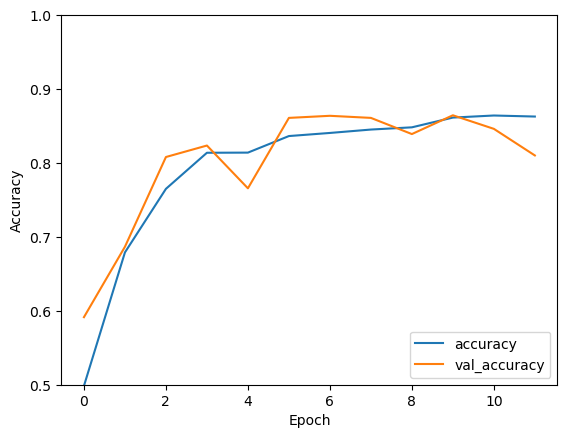

38/38 [==============================] - 4s 91ms/step
[0.8222222222222222, 0.925, 0.74, [[444, 36], [156, 564]]]
[99626, 872104, 1073460, 327292, 130322, 300908, 28725, 934597, 351958, 891631, 186098, 1062387, 245444, 226866, 39320, 179873, 872328, 233536, 84362, 568415, 421325, 890976, 872143, 459996, 792048, 704709, 956760, 704784, 1043862, 303429, 303438, 930778, 872123, 28766, 327335, 872135, 67825, 53502, 493855, 81287, 809717, 845594, 1090250, 344330, 704759, 951698, 81964, 303476, 997170, 351007, 872090, 64128, 891632, 704779, 916348, 801206, 872160, 704760, 233661, 956716, 790304, 872134, 266472, 661364, 79878, 872119, 645163, 53482, 327330, 365475, 99612, 397954, 920408, 872129, 764285, 1025570, 140153, 67824, 130271, 327284, 53496, 846582, 207011, 872155, 300903, 845588, 913143, 605837, 934560, 295392, 21175, 53531, 951694, 53460, 351950, 1014121, 53491, 130323, 579634, 53488, 575015, 327321, 872102, 179859, 300967, 1006220, 618007, 934596, 790351, 858600, 1006156, 327282, 10

Text(0, 0.5, 'Actual class')

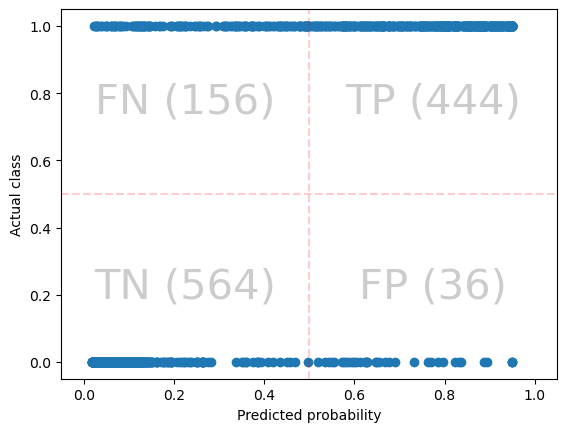

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

pred_prob = cnn.predict(xtest)
ypred = np.round(pred_prob)

p = performance(ytest, ypred)
print(p)
measIDs_FN = [measIDs_test[i] for i in range(len(ytest)) if ytest[i] == 1 and ypred[i] == 0]
measIDs_FP = [measIDs_test[i] for i in range(len(ytest)) if ytest[i] == 0 and ypred[i] == 1]
probs_wrong = [pred_prob[i][0] for i in range(len(ytest)) if ytest[i] != ypred[i]]
print(measIDs_FN)
print(measIDs_FP)
print(probs_wrong)

plt.scatter(pred_prob, ytest)
plt.hlines(0.5, -0.05, 1.05,'r','dashed', alpha=0.2)
plt.vlines(0.5, -0.05, 1.05,'r','dashed', alpha=0.2)
plt.text(0.775, 0.775, 'TP ('+str(p[3][0][0])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.775, 0.225, 'FP ('+str(p[3][0][1])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.225, 0.775, 'FN ('+str(p[3][1][0])+')', size=30, ha="center", va="center", alpha=0.2)
plt.text(0.225, 0.225, 'TN ('+str(p[3][1][1])+')', size=30, ha="center", va="center", alpha=0.2)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Predicted probability')
plt.ylabel('Actual class')

In [42]:
# print(meas_test)
meas_pt_test =  list(measIDs_pt_test_AF) + list(measIDs_pt_test_noAF)
xtest_pt_unfilt, meas_pt_test = ecg.store_ecg_data(measIDs=meas_pt_test, study='trial', permute = False)
print(meas_pt_test)
print('Extracted data')
xtest_pt = np.array(filter_signals(xtest_pt_unfilt))
print('Filtered data')
ytest_pt = np.array([1]*len(measIDs_pt_test_AF) + [0]*len(measIDs_pt_test_noAF))
print('Produced classes')

0it [00:00, ?it/s]

[]
Extracted data
Filtered data
Produced classes


In [43]:
TP, FP, FN, TN = 0, 0, 0, 0

pt_results = []
for i in pt_test:
    pt_measIDs = ecg.extract_pt_measIDs(i, study = 'trial')
    pt_measIDs = [i for i in pt_measIDs if i in meas_test and ecg.extract_measDiag([i])[0] != 5]
    pt_diag = ecg.extract_ptDiag(i, study = 'trial')
    if len(pt_measIDs) != 0:
        xtest_pt_unfilt, meas_pt_test = ecg.store_ecg_data(measIDs=pt_measIDs, study='trial', permute = False)
        xtest_pt = np.array(filter_signals(xtest_pt_unfilt))
        pred_prob = cnn.predict(xtest_pt, verbose = 0)
        ypred_pt = np.round(pred_prob)
        if 1 in ypred_pt:
            pt_pred_diag = 1
        else:
            pt_pred_diag = 3
    else:
        pt_pred_diag = 3

    if pt_diag == pt_pred_diag:
        if pt_pred_diag == 1: TP += 1
        if pt_pred_diag == 3: TN += 1
    else:
        if pt_pred_diag == 3: FN += 1
        if pt_pred_diag == 1: FP += 1
    
    pt_results.append([i, pt_diag, pt_pred_diag])

print([[TP, FP], [FN, TN]])

100%|██████████| 70/70 [00:02<00:00, 24.53it/s]
C:\Users\docto\AppData\Local\Temp\ipykernel_3984\4193393747.py:27: RuntimeWarning: invalid value encountered in divide
  norm_ecg_signals.append((np.array(i)-np.mean(i))/np.std(i))
100%|██████████| 61/61 [00:02<00:00, 24.64it/s]


[[99, 261], [14, 1262]]


In [45]:
TP, FP, FN, TN = 0, 0, 0, 0
print(pt_test)
pt_measIDs_lens = []
pt_measIDs_global = []
pt_diags = []
for i in tqdm(pt_test):
    pt_measIDs = ecg.extract_pt_measIDs(i, study = 'trial')
    pt_measIDs_lens.append(0)
    for j in pt_measIDs:
        if j in meas_test:
            pt_measIDs_global.append(j)
            pt_measIDs_lens[-1] += 1

    pt_diags.append(ecg.extract_ptDiag(i, study = 'trial'))
xtest_pt_unfilt, pt_measIDs_global = ecg.store_ecg_data(measIDs=pt_measIDs_global, study='trial', permute = False)
xtest_pt = np.array(filter_signals(xtest_pt_unfilt))
pred_prob = cnn.predict(xtest_pt, verbose = 0)
ypred_pt = np.round(pred_prob)

j = 0
for i in tqdm(range(len(pt_test))):

    if 1 in ypred_pt[j:j+pt_measIDs_lens[i]]:
        pt_pred_diag = 1
    else:
        pt_pred_diag = 3
    
    if pt_diags[i] == pt_pred_diag:
        if pt_pred_diag == 1: TP += 1
        if pt_pred_diag == 3: TN += 1
    else:
        if pt_pred_diag == 3: FN += 1
        if pt_pred_diag == 1: FP += 1

print([[TP, FP], [FN, TN]])

[12185, 1357, 4686, 9238, 11018, 6013, 6437, 4195, 11975, 3112, 9756, 3153, 7181, 5678, 12451, 1635, 9790, 8998, 11033, 11427, 6727, 12060, 2558, 9393, 12491, 5473, 4237, 9869, 1501, 13205, 8921, 8728, 3575, 3881, 1673, 7328, 6003, 4396, 8675, 7501, 13166, 6555, 8274, 247, 5717, 11926, 5001, 5991, 644, 1812, 9860, 10956, 383, 2951, 5278, 5023, 10123, 9976, 11882, 918, 1852, 9955, 7484, 4288, 8002, 559, 13051, 8226, 5455, 12311, 5394, 10985, 4159, 2520, 6530, 1263, 4267, 4877, 5799, 6623, 11973, 12728, 11839, 10051, 7794, 11732, 4041, 12246, 5805, 2349, 6924, 8604, 11510, 11414, 793, 7440, 7547, 712, 261, 12442, 12732, 8025, 5585, 10761, 2530, 1520, 10749, 220, 6648, 11829, 1308, 12359, 8115, 8441, 5874, 3208, 5724, 4008, 11687, 11631, 5252, 7942, 10490, 8598, 4568, 3493, 8414, 3994, 12018, 4, 7955, 6063, 10404, 10555, 13243, 1526, 6026, 5616, 5283, 6075, 12852, 4186, 5433, 8340, 1306, 7976, 9656, 7354, 7578, 11877, 9653, 1467, 4550, 4115, 8881, 8874, 5861, 6098, 4156, 7022, 5638, 2060,

100%|██████████| 45052/45052 [30:12<00:00, 24.86it/s]
C:\Users\docto\AppData\Local\Temp\ipykernel_3984\4193393747.py:27: RuntimeWarning: invalid value encountered in divide
  norm_ecg_signals.append((np.array(i)-np.mean(i))/np.std(i))
100%|██████████| 1636/1636 [00:00<00:00, 58444.25it/s]

[[46, 166], [67, 1357]]


In [ ]:
pred_prob = cnn.predict(xtest_pt)
ypred_pt = np.round(pred_prob)
print(len(ypred_pt))
p = performance(ytest_pt, ypred_pt)
print('Performance: ', p)
measIDs_wrong = [meas_pt_test[i] for i in range(len(ytest_pt)) if ytest_pt[i] != ypred_pt[i]]
print('Found incorrect measIDs')
pt_wrong = []
for i in measIDs_wrong:
    for j in ecg_tags_reviewed:
        if j[2] == i and j[0] not in pt_wrong:
            pt_wrong.append(j[0])
print('Patients sent to review')
nptAF = sum([1 for i in pt_test if i in patients_AF])
FP = sum([1 for i in pt_wrong if i not in patients_AF])
FN = sum([1 for i in pt_wrong if i in patients_AF])
TP = nptAF - FN
TN = len(pt_test) - FP - FN - TP
print([[TP, FP], [FN, TN]])

56/56 [==============================] - 3s 54ms/step
1784
Performance:  [0.6869565217391305, 0.5791788856304986, 0.844017094017094, [[395, 287], [73, 1029]]]
Found incorrect measIDs
Patients sent to review
[[56, 174], [37, 1369]]


In [ ]:
xtrain = np.array(filter_signals(data_train))
xval = np.array(filter_signals(data_val))
xtest = np.array(filter_signals(data_test))

print(sum(ytrain), sum(yval), sum(ytest))

ks = 20

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu', input_shape=[15200,1]))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Conv1D(filters=16, kernel_size=ks, activation='relu'))
cnn.add(tf.keras.layers.MaxPool1D(pool_size=10, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='sigmoid'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn.fit(xtrain, ytrain, epochs=24, validation_data=(xval, yval))

pred_prob = cnn.predict(xtest)
ypred = np.round(pred_prob)

p = performance(ytest, ypred)
print(p)

1600 817 787
Epoch 1/24
100/100 [==============================] - 40s 385ms/step - loss: 0.7108 - accuracy: 0.5219 - val_loss: 0.6746 - val_accuracy: 0.5417
Epoch 2/24
100/100 [==============================] - 41s 408ms/step - loss: 0.6724 - accuracy: 0.5612 - val_loss: 0.6405 - val_accuracy: 0.6246
Epoch 3/24
100/100 [==============================] - 37s 373ms/step - loss: 0.5553 - accuracy: 0.7297 - val_loss: 0.4698 - val_accuracy: 0.7953
Epoch 4/24
100/100 [==============================] - 38s 379ms/step - loss: 0.4790 - accuracy: 0.7806 - val_loss: 0.4490 - val_accuracy: 0.7922
Epoch 5/24
100/100 [==============================] - 40s 403ms/step - loss: 0.4254 - accuracy: 0.8097 - val_loss: 0.3715 - val_accuracy: 0.8423
Epoch 6/24
100/100 [==============================] - 42s 425ms/step - loss: 0.3948 - accuracy: 0.8300 - val_loss: 0.3983 - val_accuracy: 0.8225
Epoch 7/24
100/100 [==============================] - 40s 405ms/step - loss: 0.3888 - accuracy: 0.8334 - val_loss: 0.

In [ ]:
print(performance(ytest, ypred))
measIDs_FN = [measIDstest[i] for i in range(len(ytest)) if ytest[i] == 1 and ypred[i] == 0]
measIDs_FP = [measIDstest[i] for i in range(len(ytest)) if ytest[i] == 0 and ypred[i] == 1]
probs_wrong = [pred_prob[i][0] for i in range(len(ytest)) if ytest[i] != ypred[i]]
print(measIDs_FN)
print(measIDs_FP)
print(probs_wrong)

[0.842042042042042, 0.792090395480226, 0.8987179487179487, [[701, 184], [79, 622]]]
[496976, 327322, 91565, 1025577, 872325, 327304, 962189, 1006147, 233568, 964470, 623142, 226845, 430444, 934535, 300914, 845602, 801206, 1076246, 956717, 974257, 723479, 519785, 335117, 135380, 434145, 858600, 519063, 959186, 775797, 365475, 731566, 370823, 193490, 825244, 1043861, 53503, 340794, 351007, 327312, 872327, 41850, 1018344, 438286, 1025579, 929890, 340787, 1006211, 68942, 300940, 245444, 845589, 661364, 135333, 233594, 438119, 25786, 365061, 845611, 245445, 789429, 368871, 17576, 974196, 213000, 690141, 1048718, 370824, 798086, 845655, 704709, 217965, 469099, 845622, 351000, 1007193, 1043862, 523528, 974199, 327274]
[949799, 1072101, 399944, 559522, 63372, 1067092, 6728, 482446, 340118, 3148, 231908, 262785, 745957, 1020587, 1069609, 518739, 188170, 102105, 1064884, 845996, 309543, 381384, 45662, 447987, 567570, 432432, 713528, 918896, 1093946, 961656, 481084, 445417, 707950, 949851, 106709

In [ ]:
# start, end = 6000, 10000

# for i in measIDs_FN:
#     fig, ax = plt.subplots(2,1)
#     fig.set_figwidth(18)
#     fig.set_figheight(10)
#     ax[0].plot(filter_signals([ecg.extract_signal(i, study='trial')])[0][start:end])
#     ax[0].set_title('Filtered signal')
#     ax[1].plot(ecg.extract_signal(i, study='trial')[start:end]/1000)
#     ax[1].set_title('Raw signal')
#     fig.suptitle('False Negative for measID '+str(i)+' in trial', fontsize=18)
#     fig.savefig('E:\IIB Project\Experiments\Experiment 6\FN\FN'+str(i)+'.png', bbox_inches='tight')

# for i in measIDs_FP:
#     fig, ax = plt.subplots(2,1)
#     fig.set_figwidth(18)
#     fig.set_figheight(10)
#     ax[0].plot(filter_signals([ecg.extract_signal(i, study='trial')])[0][start:end])
#     ax[0].set_title('Filtered signal')
#     ax[1].plot(ecg.extract_signal(i, study='trial')[start:end]/1000)
#     ax[1].set_title('Raw signal')
#     fig.suptitle('False Positive for measID '+str(i)+' in trial', fontsize=18)
#     fig.savefig('E:\IIB Project\Experiments\Experiment 6\FP\FP'+str(i)+'.png', bbox_inches='tight')